In [1]:
import numpy as np
import matplotlib.pyplot as plt

## V2
By including the idea of block time , the followings are the goals :
- Using simulation to check whether the misprcing process $M_n$ has stationary distribution ? 
- (Same goal as before) Asymptotic growth rate of wealth , fee and arbitrageur's profit . 
- Relation between LVR , LP's wealth and arb's profit in this case ?

Here we consider the discrete time model and set the time unit to be the time interval between
two successive  market price updates . So block time equals to $N$ means that market price moves
$N$ times during the generation of new block . 

In [42]:
def position(L,S_p):
    X = L * (np.sqrt(S_p) - np.sqrt(P_a) )
    Y = L * (1/np.sqrt(S_p) - 1/np.sqrt(P_b))
    return X,Y
def wealth(L,S_p , S_m):
    return position(L,S_p)[0]+ S_m*position(L,S_p)[1]

def pool_process( gamma , block_time ,S_p_ini , S_m_array ):
    length = len(S_m_array)
    S_p_array = np.zeros(length)
    S_p_array[0]= S_p_ini
    N = block_time
    for time in range(1,length):
        if time %N==0 : #update
            if S_m_array[time] >  S_p_array[time-1]*gamma**(-1) :

                S_p_array[time] =  S_m_array[time]*gamma

            elif S_m_array[time]  < S_p_array[time-1]*gamma:

                S_p_array[time] =  S_m_array[time]*gamma**(-1)

            else:
                 S_p_array[time] =  S_p_array[time-1]
        else: #no action during block time
            block_time_tick = int(np.floor(time/N)*N)
            S_p_array[time] = S_p_array[block_time_tick]
    return S_p_array

def market_process_NN( T , p ,delta , S_m_ini): #NN means nearst neighbour , same as before RW jump one step each time
    logS_m_array = np.zeros(T+1)
    for time in range(1,T+1):
        U = np.random.rand()
        if U < p :
            logS_m_array[time] = logS_m_array[time-1]+1
        else:
            logS_m_array[time] = logS_m_array[time-1]-1
            
    return np.exp(logS_m_array*delta)

def market_process_normal( T , mean , variance , S_m_ini): #normal step size
    S_m_array = np.zeros(T+1)
    S_m_array[0] = S_m_ini
    for time in range(1,T+1):
        N = np.random.normal(mean , np.sqrt(variance))
        S_m_array[time] = S_m_array[time-1]*np.exp(N)
            
    return S_m_array

### Plot price path

In [104]:
delta = 10**(-3)
gamma = 0.997

In [105]:
T= 10**6

S_m_NN_array = market_process_NN( T , 0.5 , delta , 1)
S_m_normal_array = market_process_normal( T , 0 ,  delta , 1)

S_p_NN_array = pool_process( gamma , 5 ,1 ,S_m_NN_array)
S_p_normal_array = pool_process( gamma , 5 ,1 ,S_m_normal_array)

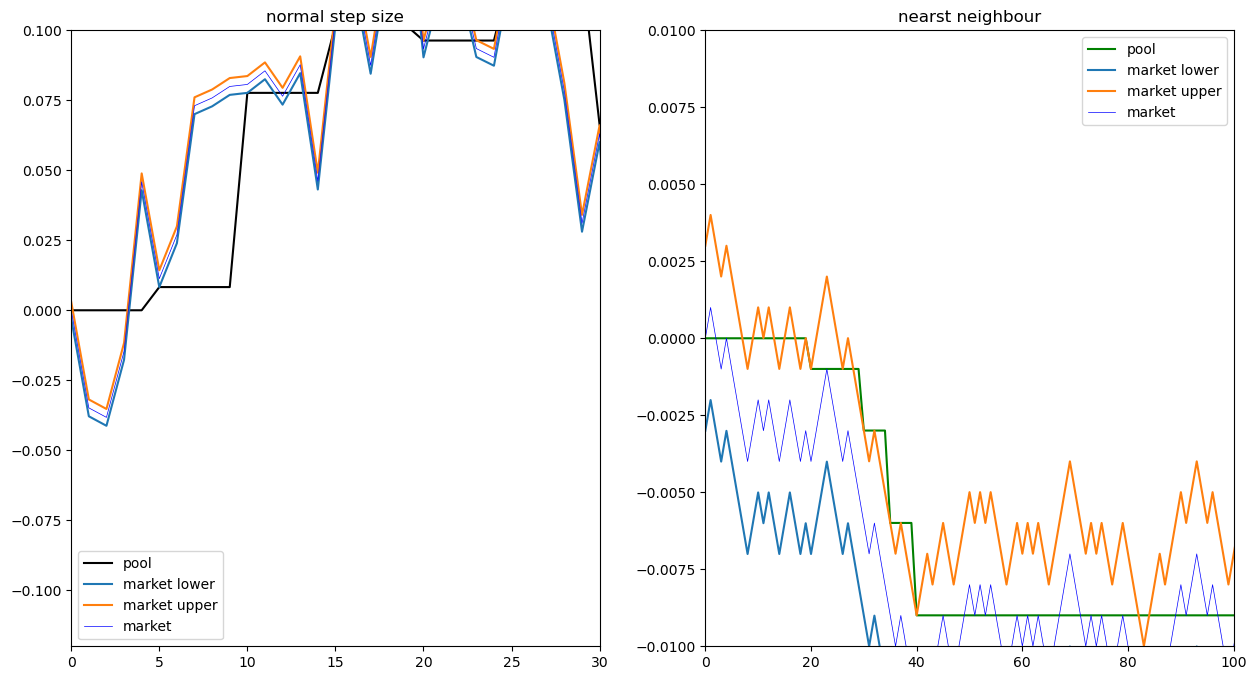

In [106]:
T_array=np.arange(T+1)
fig , ax =plt.subplots(1,2 , figsize=(15,8))
ax[0].plot(T_array, np.log(S_p_normal_array) ,'black' , label='pool')
ax[0].plot(T_array, np.log(gamma*S_m_normal_array) , label='market lower')
ax[0].plot(T_array, np.log(S_m_normal_array*(gamma**-1))  , label='market upper' )
ax[0].plot(T_array, np.log(S_m_normal_array) , 'b',linewidth=0.5 , label='market')
ax[0].set_xlim((0,30))
ax[0].set_ylim((-0.12,0.1))
ax[0].set_title("normal step size")
ax[0].legend()

ax[1].plot(T_array, np.log(S_p_NN_array) ,'g' , label='pool')
ax[1].plot(T_array, np.log(gamma*S_m_NN_array) , label='market lower')
ax[1].plot(T_array, np.log(S_m_NN_array*(gamma**-1))  , label='market upper' )
ax[1].plot(T_array, np.log(S_m_NN_array) , 'b',linewidth=0.5 , label='market')
ax[1].set_xlim((0,100))
ax[1].set_ylim((-0.01,0.01))
ax[1].set_title("nearst neighbour")
ax[1].legend()

Indeed , normal step size  has higher chance to result in larger price deviation s.t pool price is pushed more frequently .

In [107]:
def Mispricing(S_p_array , S_m_array) :
    return np.log(S_m_array) - np.log(S_p_array)

One can compare the results of different block time , if it is $1$ , then
every thing is the same as before since the market and the arbitrageur always act at the same time
, so $M_n \in [\ln \gamma  , \ln\gamma^{-1}]$ as usal . For the value greaters than $1$ , mispricing process goes outside of the no-arbitrage region . 

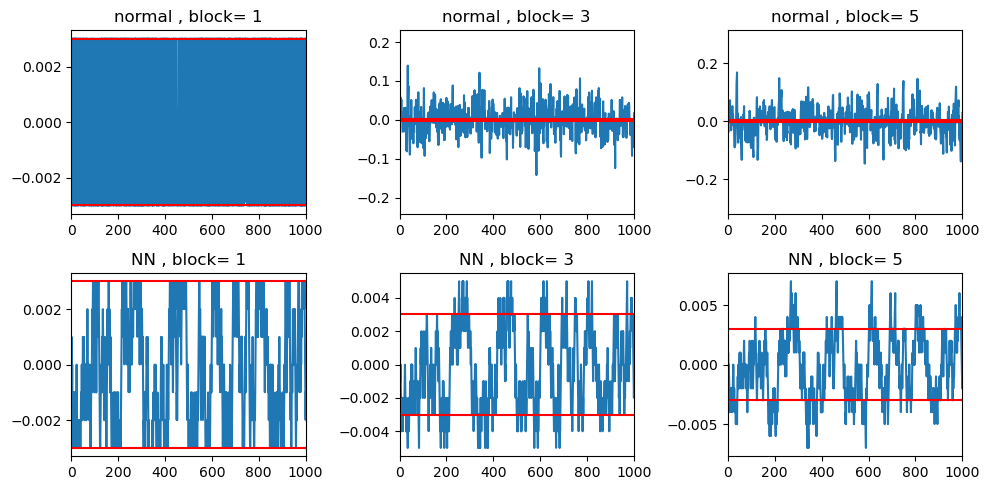

In [108]:
fig , ax = plt.subplots(2,3, figsize=(10,5))
block_time = [1,3,5]
for index in range(len(block_time)):
    l = block_time[index]
    
    S_p_normal_array = pool_process( gamma , l ,1 ,S_m_normal_array)
    M_array= Mispricing(S_p_normal_array , S_m_normal_array)
    ax[0,index].plot(M_array)
    ax[0,index].set_xlim(0,1000)
    ax[0,index].axhline(np.log(gamma) , color = 'r')
    ax[0,index].axhline(-np.log(gamma) , color = 'r')
    ax[0,index].set_title("normal , block= %d" % l)
    
    S_p_NN_array = pool_process( gamma , l ,1 ,S_m_NN_array)
    M_array= Mispricing(S_p_NN_array , S_m_NN_array)
    ax[1,index].plot(M_array)
    ax[1,index].set_xlim(0,1000)
    ax[1,index].axhline(np.log(gamma) , color = 'r')
    ax[1,index].axhline(-np.log(gamma) , color = 'r')
    ax[1,index].set_title("NN , block= %d" % l)
plt.tight_layout()


### Empirical stationary distribution of mispricing

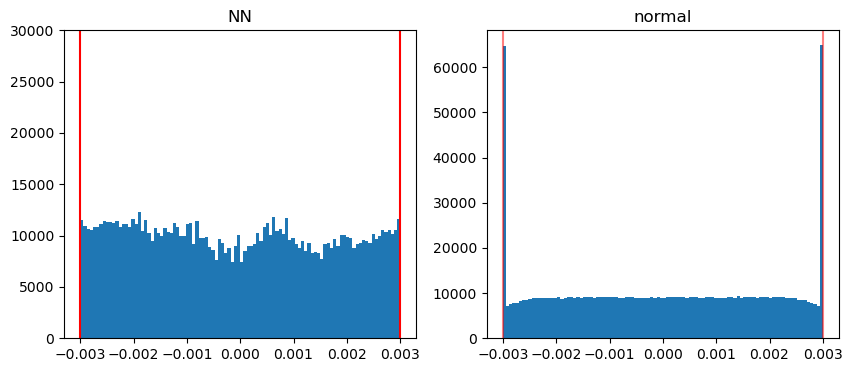

In [97]:
delta = -np.log(gamma)/100
T=10**6
def plot_compare(l):
    S_m_normal_array = market_process_normal( T , 0 , 0.01*delta , 1)
    S_p_normal_array = pool_process( gamma , l ,1 ,S_m_normal_array)

    S_m_NN_array = market_process_NN( T , 0.5 ,  delta , 1)
    S_p_NN_array = pool_process( gamma , l ,1 ,S_m_NN_array)

    M_NN_array = Mispricing(S_p_NN_array , S_m_NN_array)
    M_normal_array = Mispricing(S_p_normal_array , S_m_normal_array)
    fig , ax = plt.subplots(1,2 , figsize=(10,4))
    ax[0].hist(M_NN_array , bins = 100)
    ax[0].axvline(np.log(gamma) , color = 'r')
    ax[0].axvline(-np.log(gamma) , color = 'r')
    ax[0].set_title("NN" )
    ax[0].set_ylim(0,30000)
    
    ax[1].hist(M_normal_array , bins = 100 )
    ax[1].axvline(np.log(gamma) , color = 'r' , alpha=0.5)
    ax[1].axvline(-np.log(gamma) , color = 'r', alpha=0.5)
    #ax[1].set_xlim(-0.0030046 , -0.0029985)
    ax[1].set_title("normal" )
plot_compare(1)

For normal case , there's two peaks on boundaries $\pm \ln \gamma$ . Why? What is the proper choice of the variance and block time ?

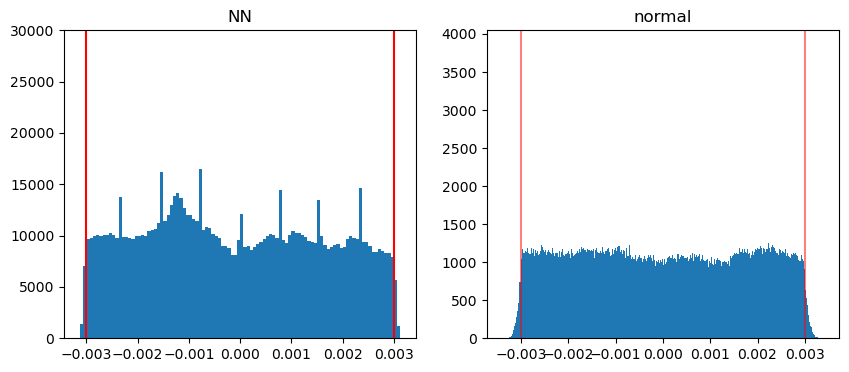

In [68]:
plot_compare(5)

Set block time to $5$ , we see that the support of asympototic distribution of mispricing exceeds the no-arbitrage region as expected.
By proper scaling of variance and block time , we should expect to approximate the result in the paper Milionis[2023] .
Still , in the next cell we can also see that the anomalously high probability at the bounday of the no-arbitrage region .

Text(0.5, 1.0, 'NN')

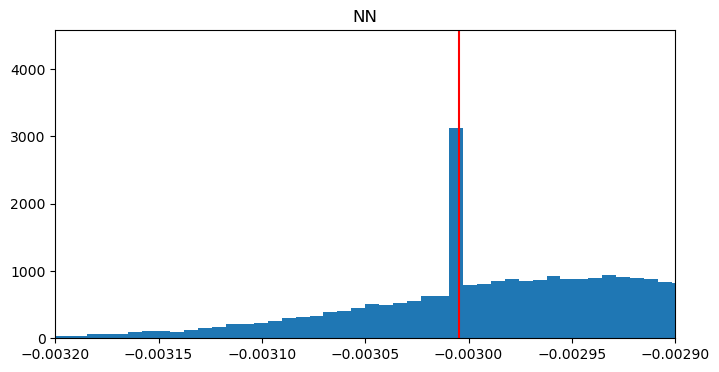

In [98]:
    S_m_normal_array = market_process_normal( T , 0 ,  10**(-4)*delta , 1)
    S_p_normal_array = pool_process( gamma , l ,1 ,S_m_normal_array)
    M_normal_array = Mispricing(S_p_normal_array , S_m_normal_array)
    fig , ax = plt.subplots(1,1 , figsize=(8,4))
    ax.hist(M_normal_array , bins = 1000)
    ax.axvline(np.log(gamma) , color = 'r')
    ax.axvline(-np.log(gamma) , color = 'r')
    ax.set_xlim(-0.0032 , -0.0029)
    ax.set_title("NN" )

Meanwhile , no such phenomenon for NN case .

Text(0.5, 1.0, 'NN')

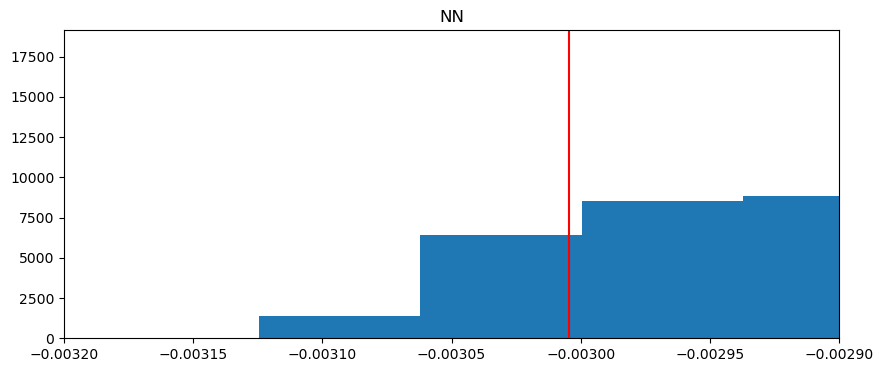

In [87]:
    S_m_NN_array = market_process_NN( T , 0.5 ,  delta , 1)
    S_p_NN_array = pool_process( gamma , l ,1 ,S_m_NN_array)
    M_NN_array = Mispricing(S_p_NN_array , S_m_NN_array)
    fig , ax = plt.subplots(1,1 , figsize=(10,4))
    ax.hist(M_NN_array , bins = 100)
    ax.axvline(np.log(gamma) , color = 'r')
    ax.axvline(-np.log(gamma) , color = 'r')
    ax.set_xlim(-0.0032 , -0.0029)
    ax.set_title("NN" )